In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import math

# Step 1: Generate the data 
I'm aiming to generate 20000 datapoints from a Gaussian mixture model of k = 100 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [51]:
n = 50000 # Number of datapoints
k = 20 # Number of components

# Randomising the weights
weights = np.random.random(size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-20.0, high=20.0, size=(k, ))
variance = np.random.uniform(low=0, high=2.0, size=(k, ))


In [52]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

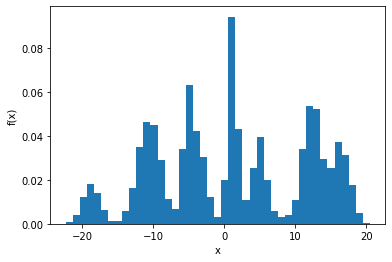

In [53]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [71]:
# First, define a way to calculate pdf 
def pdf(x, mean, var):
    assert var >= 0
    return math.exp(-0.5 * ((x - mean) ** 2 ) / var) / (math.sqrt(2 * math.pi * var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [82]:
# Define a metric to evaluate our return from EM alg.
# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
def KL_div(pred_mean, pred_var, pred_weights):
    KL_divergence = 0
    for i in range(n):
        P_value = 0
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_var[j])
            P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value * math.log(P_value/Q_value, math.e) #- P_value + Q_value
    
    return KL_divergence
assert KL_div(mean, variance, weights) == 0

In [83]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 
def traditional_EM():
    predicted_mean = np.random.uniform(low=-5, high=5, size=(k, ))
    predicted_variance = np.random.uniform(low=0, high=5, size=(k, ))
    predicted_weights = np.random.random(size=(k, ))
    predicted_weights = predicted_weights / np.sum(predicted_weights) 
    
    KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
    print("kl div:", KL_divergence)
    
    while KL_divergence > 35:
        
        probability_matrix = np.zeros((n, k))
        normalised_p_matrix = np.zeros((n, k))
        for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
                denominator_sum += probability_matrix[i, j]
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum
        
        
        for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
                
        #print(predicted_mean)
        for j in range(k):
            predicted_weights[j] = (1/n) * np.sum(probability_matrix[:, j])
            predicted_mean[j] = np.sum(normalised_p_matrix[:, j] * data)
            
            predicted_variance[j] = np.sum(normalised_p_matrix[:, j] * (data - predicted_mean[j]) ** 2)
            
        assert predicted_variance.all() > 0
        assert abs(np.sum(predicted_weights) - 1) < 0.0000001
        
        KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
        print("kl div:", KL_divergence)
        
    return predicted_mean, predicted_variance, predicted_weights


predicted_mean, predicted_variance, predicted_weights = traditional_EM()
print(predicted_mean, predicted_variance, predicted_weights)
print(mean, variance, weights)


kl div: 9028.01931858272
kl div: 1076.469900107576
kl div: 908.2022929756313
kl div: 794.110635395626
kl div: 690.0130556580931
kl div: 586.4159156626114
kl div: 499.2939653303597
kl div: 436.1422710203223
kl div: 394.1865467649598
kl div: 368.05644799148376
kl div: 350.13033626384845
kl div: 335.59304323341615
kl div: 322.184014934155
kl div: 309.41692733725586
kl div: 298.0005561727717
kl div: 288.580560060142
kl div: 280.34306945196954
kl div: 270.50464786725337
kl div: 254.56566048225943
kl div: 230.6010952948011
kl div: 204.8419692669276
kl div: 183.52137583975315
kl div: 168.1378821130281
kl div: 157.69852502740122
kl div: 150.67139164517351
kl div: 145.84253311161305
kl div: 142.4147438051885
kl div: 139.89702923863737
kl div: 137.9907957772682
kl div: 136.51083121928724
kl div: 135.3374287708743
kl div: 134.38936116538042
kl div: 133.60909637960933
kl div: 132.95466695404056
kl div: 132.39500689988094
kl div: 131.90707149721285
kl div: 131.47388288573865
kl div: 131.08307107706

KeyboardInterrupt: 